# Continuous and Categorical Features Evaluation Report

In [36]:
# Imports
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import sklearn.metrics 
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

import numpy as np
import pylab as pl
import csv


In [37]:
# taken and modified from sklearn to load csv in scikit learn standard format
class Bunch(dict):

    def __init__(self, **kwargs):
        super(Bunch, self).__init__(kwargs)

    def __setattr__(self, key, value):
        self[key] = value

    def __dir__(self):
        return self.keys()

    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)

    def __setstate__(self, state):
        pass

cont_infile_name = '../data/preprocessed_divvy_weather/evaluation_continuous_categorical.csv'

def load_divydata(return_X_y=False):  
    with open(cont_infile_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        n_samples = int(temp[0])
        n_features = int(temp[1])
        data = np.empty((n_samples, n_features))
        target = np.empty((n_samples,))
        temp = next(data_file)
        feature_names = np.array(temp)

        for i, d in enumerate(data_file):
            data[i] = np.asarray(d[:-1], dtype=np.float64)
            target[i] = np.asarray(d[-1], dtype=np.float64)

    if return_X_y:
        return data, target

    return Bunch(data=data,
                 target=target,
                 feature_names=feature_names[:-1])

In [38]:
# Load data set
divy = load_divydata()
print (divy.feature_names)

['TemperatureF' 'Dew_PointF' 'Humidity' 'Sea_Level_PressureIn' 'VisibilityMPH' 'Wind_SpeedMPH' 'WindDirDegrees'
 'Event_Fog' 'Event_Normal' 'Event_Rain' 'Event_Rain_Hail_Thunderstorm' 'Event_Rain_Snow' 'Event_Rain_Thunderstorm'
 'Event_Snow' 'Event_Thunderstorm' 'Conditions_Clear' 'Conditions_Fog' 'Conditions_Haze' 'Conditions_Heavy_Rain'
 'Conditions_Heavy_Thunderstorms_and_Rain' 'Conditions_Light_Drizzle' 'Conditions_Light_Rain' 'Conditions_Light_Snow'
 'Conditions_Light_Thunderstorms_and_Rain' 'Conditions_Mostly_Cloudy' 'Conditions_Overcast' 'Conditions_Partly_Cloudy'
 'Conditions_Rain' 'Conditions_Scattered_Clouds' 'Conditions_Shallow_Fog' 'Conditions_Thunderstorm'
 'Conditions_Thunderstorms_and_Rain' 'Conditions_Unknown' 'Wind_Direction_Calm' 'Wind_Direction_ENE'
 'Wind_Direction_ESE' 'Wind_Direction_East' 'Wind_Direction_NE' 'Wind_Direction_NNE' 'Wind_Direction_NNW'
 'Wind_Direction_NW' 'Wind_Direction_North' 'Wind_Direction_SE' 'Wind_Direction_SSE' 'Wind_Direction_SSW'
 'Wind_Di

In [39]:
#Printing data shape features and instances.
data_shape = divy.data.shape
print("Divy Data Shape:")
print("Instances: ",data_shape[0])
print("Features: ",data_shape[1])

Divy Data Shape:
Instances:  2057
Features:  51


# Performance Indicators

### We are using root square error, RMSE and R2 score as our performance measure for regression. 
Our trained model must work better then predicting mean. If we are only predicting near to mean then its almost similar in classification that one is predicting the mode class.
R^2 is coefficient of deteremination. 
R^2 = 1-RSE. bigger the R^2 means better the model is.
If RSE is closer to 1, it means our performance is only comparable to predicting the mean, it is a bad trained model.
If RSE is closer to zero, this indicates a better fit on data.

y:  True Function

g:  Estimated Function

u: Mean of True Function

$$RSE=\sum_{i=0}^\infty \frac{(y - g)^2}{(y - u)^2}$$

One problem with the R2 as a measure of model validity is that, it can always be increased by adding more variables into the model, except in the unlikely event that the additional variables are exactly uncorrelated with the dependent variable in the data sample being used.

Outliers may also give a distorted value of R^2.

In [40]:
# Setting print format
np.set_printoptions(precision=2, linewidth=120, suppress=True, edgeitems=4)

In [41]:
# Adding Bias term x0 in data set.
x = np.array([np.concatenate((v,[1])) for v in divy.data])

In [42]:
# Assign target data to target variable y
y = divy.target

In [43]:
# Helper functions:
# Function to take log of target variable, linear regression sometimes predict -ve values, 
# Keeping target variable on log scale avoids it.
# Below are some fuctions to alter target and prediction on a different scale to avoid this problem.
# Other utility functions

# target variable to log scale
def target_to_ln(y):
    neg_inf = .001
    tmp_t = []
    for t in y:
        if 0==t:
            tmp_t.append(neg_inf)
        else:
            tmp_t.append(np.log(t))
    return tmp_t

# Rescaling of predictions from log
def ln_to_target(p):
    tmp_t = []
    for t in p:
        tmp_t.append(np.exp(t))
    return tmp_t

# Truncate -ve predictions
def truncate_neg_predictions(p):
    t = []
    for items in p:
        if items <0:
            t.append(0)
        else:
            t.append(items)
    return t

# Scaling of target to square root
def scale_var_on_sqrt(var):
    t= []
    t= var
    for index, items in enumerate(t):
        t[index] = np.sqrt(t[index])
    return t

# Rescaling of target from square root
def rescale_var_from_sqrt(var):
    t= []
    t= var
    for index, items in enumerate(t):
        t[index] = np.square(t[index])
    return t

# Cross validation computations for different models
def cross_validation_computations(clf, folds, x, y):
    kf = KFold(len(x), n_folds=folds, shuffle=True)
    xval_err = 0
    z_error = 0
    for train,test in kf:
        clf.fit(x[train],y[train])
        z_ = y[test]
        z_mean = y[test] - np.mean(z_)
        pred = clf.predict(x[test])
        e = pred-y[test]
        xval_err += np.dot(e,e)
        z_error += np.dot(e,e)/np.dot(z_mean,z_mean)

    rmse_10cv = np.sqrt(xval_err/len(x))
    rse_10cv = z_error/folds
    r2_10cv = 1-z_error/folds

    clf.fit(x,y)
    r2_score = cross_val_score(clf, x, y, cv=folds, scoring ='r2')
    return rmse_10cv, rse_10cv, r2_10cv, r2_score

# Computation over trained data
def train_data_computations(clf, x,y):

    #Predicting on train data itself
    pred = clf.predict(x)

    # Errors on train data
    err = abs(pred - y)

    #calculating mean on target variable
    meanr = np.mean(y)
    z = y
    z = abs(z-meanr)
    error = np.dot(err,err)

    # Computing RMSE
    train_rmse_err = np.sqrt(error/len(pred))

    # Computing RSE
    rse_error_pred = error / np.dot(z,z)
    r2_train_error = 1-rse_error_pred
    return meanr, train_rmse_err, rse_error_pred, r2_train_error

# Printing features in decreasing order of coefficients : Shows important features in begining
def prinitng_imp_features(clf):
    
    #print ('Regression Coefficients: \n', clf.coef_)
    a = clf.coef_.tolist()
    b = divy.feature_names.tolist()
    c = list(zip(a,b))
    c.sort(key=lambda k: k[0], reverse=True)
    for iter_ in c:
        print("%.3f  %s" %(iter_[0], iter_[1]))

# Fix the kfolds to 10
test_kfolds = 10

## Models of regression different approach for the project:
1. Linear regression
2. Ridge regression(different alpha values)
3. Lasso regression(different alpha values)
4. All three regression models with polynomial features of degree 2 and degree 3.
5. cross validation 10 folds on all of them.
6. Measures used RMSE, RSE and R2.

# Baseline for regression

### Baseline for Mean Regression

In [44]:
#baseline predictor using dummy regressor
def baseline_predict(x, y):
    y_mean = np.mean(y)
    p_base = np.array([y_mean]*len(y))
    err = abs(p_base-y)
    error = np.dot(err,err)
    train_rmse_err = np.sqrt(error/len(p_base))
    return train_rmse_err, p_base

dummy = DummyRegressor(strategy = 'mean')
dummy.fit(x,y)
p_base = dummy.predict(x)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(dummy, x,y)

#Predicting baseline on train data itself
print("BaseLine mean Regression stats on train data:")
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))
print("R^2 is  \t\t:%.3f"%(r2_train_error))

print("")

rmse_10cv, rse_10cv, r2_10cv, r2_score = cross_validation_computations(dummy, test_kfolds, x, y)
print("BaseLine mean Regression stats on 10fold cv:")
print ("RMSE over train data is: ", rmse_10cv)
print("Rse is  \t\t:%.3f"%( rse_10cv))
#print("R^2 is  \t\t:%.3f"%(r2_10cv))
print("R^2 is  \t\t:%.3f"%(np.mean(r2_score)))

baseline_mean_RMSE =  train_rmse_err
baseline_mean_r2 =  r2_train_error
baseline_mean_RMSE_c =  rmse_10cv
baseline_mean_r2_c =  np.mean(r2_score)

BaseLine mean Regression stats on train data:
MEean of target is : 9.3422459893
RMSE over train data is:  12.9547857905
Rse is  		:1.000
R^2 is  		:0.000
R^2 is  		:0.000

BaseLine mean Regression stats on 10fold cv:
RMSE over train data is:  12.9624379683
Rse is  		:1.006
R^2 is  		:-0.292


### Baseline for Median Regression

In [45]:
dummy = DummyRegressor(strategy = 'median')
dummy.fit(x,y)
p_base = dummy.predict(x)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(dummy, x,y)

#Predicting baseline on train data itself
print("BaseLine median Regression stats on train data:")
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))
print("R^2 is  \t\t:%.3f"%(r2_train_error))

print("")

rmse_10cv, rse_10cv, r2_10cv, r2_score = cross_validation_computations(dummy, test_kfolds, x, y)
print("BaseLine median Regression stats on 10fold cv:")
print ("RMSE over train data is: ", rmse_10cv)
print("Rse is  \t\t:%.3f"%( rse_10cv))
#print("R^2 is  \t\t:%.3f"%(r2_10cv))
print("R^2 is  \t\t:%.3f"%(np.mean(r2_score)))
baseline_median_RMSE =  train_rmse_err
baseline_median_r2 =  r2_train_error
baseline_median_RMSE_c =  rmse_10cv
baseline_median_r2_c =  np.mean(r2_score)


BaseLine median Regression stats on train data:
MEean of target is : 9.3422459893
RMSE over train data is:  14.4239578156
Rse is  		:1.240
R^2 is  		:-0.240
R^2 is  		:-0.240

BaseLine median Regression stats on 10fold cv:
RMSE over train data is:  14.4239578156
Rse is  		:1.241
R^2 is  		:-0.302


# Trying Linear Regression on Linear Features

In [46]:
#Linear regression object
lin_reg = LinearRegression()

#Trying to fit Linear regression object on whole data
lin_reg.fit(x,y)
pred = lin_reg.predict(x)

In [47]:
meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lin_reg, x,y)

#Predicting on train data itself
print("Linear Regression stats on train data:")
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
print("")
# bigger R^2 indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))
print("R^2 is  \t\t:%.3f"%(r2_train_error))


Linear Regression stats on train data:
MEean of target is : 9.3422459893
RMSE over train data is:  9.35382904681

Rse is  		:0.521
R^2 is  		:0.479
R^2 is  		:0.479


In [48]:
# high cofficient represents high co-relation with target variable
# printing features in sorted order of cofficient
prinitng_imp_features(lin_reg)

80742276168943.969  Conditions_Overcast
80742276168943.688  Conditions_Mostly_Cloudy
80742276168943.562  Conditions_Scattered_Clouds
80742276168943.281  Conditions_Light_Drizzle
80742276168942.172  Conditions_Clear
80742276168942.125  Conditions_Partly_Cloudy
80742276168940.312  Conditions_Haze
80742276168934.500  Conditions_Unknown
79955341482014.219  Event_Snow
31955569731395.070  Conditions_Heavy_Rain
31955569731388.430  Conditions_Light_Rain
31955569731384.578  Conditions_Rain
109.918  TemperatureF
24.519  Humidity
8.927  Wind_SpeedMPH
1.270  WindDirDegrees
-0.402  Sea_Level_PressureIn
-2.021  VisibilityMPH
-84.388  Dew_PointF
-9868878965589.594  Event_Fog
-13828391266825.672  Wind_Direction_Calm
-13828391266826.395  Wind_Direction_ENE
-13828391266827.617  Wind_Direction_South
-13828391266827.633  Wind_Direction_East
-13828391266827.680  Wind_Direction_SW
-13828391266827.711  Wind_Direction_NE
-13828391266828.355  Wind_Direction_Variable
-13828391266828.453  Wind_Direction_NNE
-138

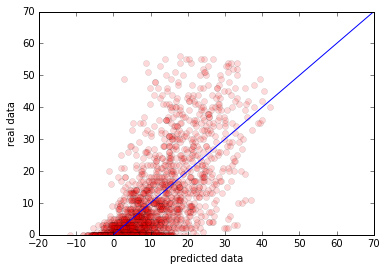

In [49]:
# How well we are doing on train data
# following figure graph shows the how linear regression fits predicted and actual on train data itself.
# It tells us how well it has fit the data itself.

%matplotlib inline
pl.plot(pred, y,'ro', alpha = 0.15)
pl.plot([0,70],[0,70], 'b-')
pl.xlabel('predicted data')
pl.ylabel('real data')
pl.show()


In [50]:
# Cv10 on linear regression
rmse_10cv, rse_10cv, r2_10cv, r2_score = cross_validation_computations(lin_reg, test_kfolds, x, y)
method_name = 'Simple Linear Regression'
print("Stats CV10:")
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %train_rmse_err)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print('R2 on 10-fold CV: %.4f' %np.mean(r2_score))

lin_reg_RMSE =  train_rmse_err
lin_reg_r2 =  r2_train_error
lin_reg_RMSE_c =  rmse_10cv
line_reg_r2_c =  np.mean(r2_score)

Stats CV10:
Method: Simple Linear Regression
RMSE on training: 9.3538
RMSE on 10-fold CV: 5573131645594.5654
R2 on 10-fold CV: -1221135281426077587603456.0000


# Now trying Ridge Regression on Linear Features

In [51]:
# Creating ridge regression object with a ridge coefficient (alpha) 0.5
ridge_reg = Ridge(fit_intercept=True, alpha=0.5)

# Training the model using the training set
ridge_reg.fit(x,y)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [52]:
# Computing RMSE on training data for ridge regression
meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(ridge_reg, x,y)
print("Stats for ridge: over train data")
method_name = 'Ridge Regression'
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)

# bigger R^2 indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))

Stats for ridge: over train data
MEean of target is : 9.3422459893
RMSE over train data is:  9.33870985808
Rse is  		:0.520
R^2 is  		:0.480


In [53]:
prinitng_imp_features(ridge_reg)

57.591  TemperatureF
8.699  Wind_SpeedMPH
4.230  Event_Rain_Snow
3.051  Wind_Direction_ENE
2.667  Conditions_Heavy_Rain
2.196  Conditions_Heavy_Thunderstorms_and_Rain
2.184  Conditions_Unknown
1.695  Conditions_Light_Rain
1.620  Wind_Direction_Calm
1.596  Wind_Direction_SW
1.516  Wind_Direction_NE
1.460  Wind_Direction_South
1.359  Event_Normal
1.349  Wind_Direction_East
1.226  Wind_Direction_NNE
1.171  Conditions_Light_Snow
1.171  Event_Snow
0.786  Conditions_Light_Drizzle
0.566  Conditions_Haze
0.463  Wind_Direction_Variable
0.460  Conditions_Shallow_Fog
0.371  Conditions_Scattered_Clouds
0.124  Conditions_Overcast
-0.140  Conditions_Mostly_Cloudy
-0.147  Conditions_Light_Thunderstorms_and_Rain
-0.300  Event_Rain
-0.314  WindDirDegrees
-0.385  Wind_Direction_West
-0.389  Event_Fog
-0.425  Wind_Direction_WSW
-0.431  Conditions_Rain
-0.586  Event_Rain_Hail_Thunderstorm
-0.687  Wind_Direction_WNW
-0.742  Wind_Direction_North
-0.849  Conditions_Fog
-1.210  Wind_Direction_NNW
-1.249  Cond

#### Ridge Regression experiment for different value of alpha.

In [54]:
print('Ridge Regression')
print('alpha\t RMSE_train\t RMSE_10cv\t R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,75)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    ridge_reg = Ridge(fit_intercept=True, alpha=a)
    ridge_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(ridge_reg, test_kfolds, x, y)
    pred = ridge_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}\t {:.4f}\t\t {:.4f}\t\t {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

Ridge Regression
alpha	 RMSE_train	 RMSE_10cv	 R2cv10

0.010	 9.2804		 9.4314		 0.385686
0.348	 9.3222		 9.4758		 0.375085
0.685	 9.3543		 9.5241		 0.369647
1.023	 9.3745		 9.5109		 0.367051
1.361	 9.3882		 9.5352		 0.365774
1.699	 9.3982		 9.5186		 0.365182
2.036	 9.4060		 9.5555		 0.364977
2.374	 9.4124		 9.5607		 0.365003
2.712	 9.4177		 9.5827		 0.365172
3.049	 9.4224		 9.5720		 0.365431
3.387	 9.4266		 9.5728		 0.365746
3.725	 9.4304		 9.5816		 0.366095
4.062	 9.4339		 9.5902		 0.366463
4.400	 9.4372		 9.5979		 0.366840
4.738	 9.4403		 9.5921		 0.367218
5.076	 9.4433		 9.5852		 0.367594
5.413	 9.4462		 9.5820		 0.367962
5.751	 9.4491		 9.5804		 0.368320
6.089	 9.4519		 9.5815		 0.368668
6.426	 9.4546		 9.5939		 0.369002
6.764	 9.4574		 9.5980		 0.369322
7.102	 9.4601		 9.6038		 0.369629
7.439	 9.4627		 9.5939		 0.369920
7.777	 9.4654		 9.6034		 0.370196
8.115	 9.4681		 9.6196		 0.370458
8.453	 9.4708		 9.5997		 0.370704
8.790	 9.4734		 9.6061		 0.370935
9.128	 9.4761		 9.6091		 0.

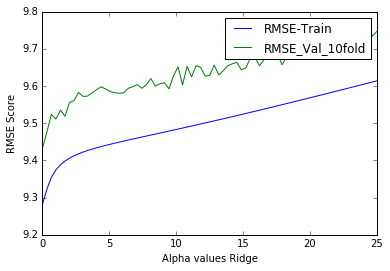

In [55]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()

# Trying Lasso Regression on Linear Features

In [56]:
# Create lasson regression object with a lso
lso_reg = Lasso(alpha=0.5)

# Train the model using the training set
lso_reg.fit(x,y)

# Computing RMSE on training data for lasso regression
meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lso_reg, x,y)

print("Stats for lasso: over train data")
method_name = 'Lasso Regression'

print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
# bigger Rse indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))

Stats for lasso: over train data
MEean of target is : 9.3422459893
RMSE over train data is:  10.1684547211
Rse is  		:0.616
R^2 is  		:0.384


### Printing Important Features 

In [57]:
prinitng_imp_features(lso_reg)

16.538  TemperatureF
0.000  Dew_PointF
-0.000  Sea_Level_PressureIn
0.000  VisibilityMPH
0.000  Wind_SpeedMPH
-0.000  WindDirDegrees
-0.000  Event_Fog
0.000  Event_Normal
-0.000  Event_Rain
-0.000  Event_Rain_Hail_Thunderstorm
0.000  Event_Rain_Snow
-0.000  Event_Rain_Thunderstorm
0.000  Event_Snow
-0.000  Event_Thunderstorm
-0.000  Conditions_Clear
-0.000  Conditions_Fog
0.000  Conditions_Haze
0.000  Conditions_Heavy_Rain
-0.000  Conditions_Heavy_Thunderstorms_and_Rain
0.000  Conditions_Light_Drizzle
-0.000  Conditions_Light_Rain
0.000  Conditions_Light_Snow
-0.000  Conditions_Light_Thunderstorms_and_Rain
0.000  Conditions_Mostly_Cloudy
-0.000  Conditions_Overcast
-0.000  Conditions_Partly_Cloudy
-0.000  Conditions_Rain
0.000  Conditions_Scattered_Clouds
-0.000  Conditions_Shallow_Fog
-0.000  Conditions_Thunderstorm
-0.000  Conditions_Thunderstorms_and_Rain
0.000  Conditions_Unknown
-0.000  Wind_Direction_Calm
0.000  Wind_Direction_ENE
-0.000  Wind_Direction_ESE
0.000  Wind_Direction_

### Lasso for different value of alpha:

In [58]:
print('Lasso Regression : ')
print('alpha        RMSE_train        RMSE_10cv        R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,75)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    lso_reg = Lasso(fit_intercept=True, alpha=a)
    lso_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(lso_reg, test_kfolds, x, y)
    pred = lso_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}        {:.4f}        {:.4f}        {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

Lasso Regression : 
alpha        RMSE_train        RMSE_10cv        R2cv10

0.010        9.3369        9.4552        0.380562
0.348        9.9683        9.9833        0.355203
0.685        10.5004        10.5095        0.254876
1.023        11.3257        11.3413        0.049879
1.361        12.3856        12.3983        -0.181711
1.699        12.9548        12.9678        -0.291677
2.036        12.9548        12.9643        -0.291677
2.374        12.9548        12.9581        -0.291677
2.712        12.9548        12.9685        -0.291677
3.049        12.9548        12.9646        -0.291677
3.387        12.9548        12.9622        -0.291677
3.725        12.9548        12.9665        -0.291677
4.062        12.9548        12.9636        -0.291677
4.400        12.9548        12.9619        -0.291677
4.738        12.9548        12.9604        -0.291677
5.076        12.9548        12.9598        -0.291677
5.413        12.9548        12.9579        -0.291677
5.751        12.9548        12.

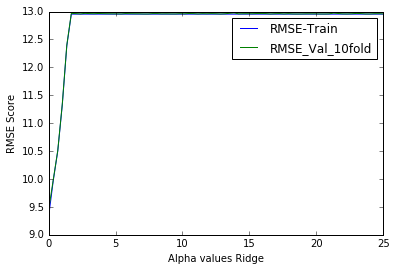

In [59]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()

# Creating Polynomial Regression of Degree 2


In [60]:
poly = PolynomialFeatures(degree=2)
x_new = poly.fit_transform(x)
x_old = x

In [61]:
print("Original Data Shape = ", x.shape)
print("Polynomial Degree 2 Data Shape = ", x_new.shape)

Original Data Shape =  (2057, 52)
Polynomial Degree 2 Data Shape =  (2057, 1431)


# Linear Regression on Polynomial Features of Degree 2

In [62]:
#Linear regression object
x=x_new

lin_reg = LinearRegression()
lin_reg.fit(x_new, y)
pred = lin_reg.predict(x_new)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lin_reg, x_new,y)
#Predicting on train data itself
print("Poly Linear Regression(degree-2) stats on train data:")
print("MEean of target is :", meanr)
print ("RMSE over train data is: ", train_rmse_err)
# bigger R^2 indicate a better fit on data.
print("Rse is  \t\t:%.3f"%( rse_error_pred))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))

Poly Linear Regression(degree-2) stats on train data:
MEean of target is : 9.3422459893
RMSE over train data is:  8.27150871079
Rse is  		:0.408
R^2 is  		:0.592


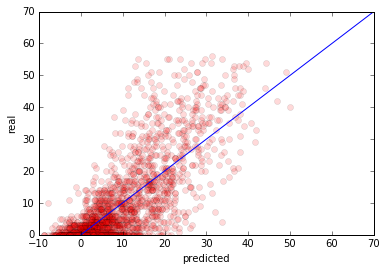

In [63]:
# This graph shows the how linear regression fits between both predicted and actual on training data itself.

# It tells us how well it has fit the data itself, for sure its not over fitting.
# Plot outputs
%matplotlib inline
pl.plot(pred, y,'ro', alpha = .15)
pl.plot([0,70],[0,70], 'b-')
pl.xlabel('predicted')
pl.ylabel('real')
pl.show()

In [64]:
# Cross Validation
rmse_10cv, rse_10cv, r2_10cv, r2_score = cross_validation_computations(lin_reg, test_kfolds, x, y)
method_name = 'Polynomial Linear Regression(degree-2)'
print("Stats CV10:")
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %train_rmse_err)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
#print('RSE on 10-fold CV: %.4f' %rse_10cv)
print('R^2 on CV=10: %.4f' %np.mean(r2_score))

Stats CV10:
Method: Polynomial Linear Regression(degree-2)
RMSE on training: 8.2715
RMSE on 10-fold CV: 15905218214708.0547
R^2 on CV=10: -14668985654110171374288896.0000


# Trying Ridge Regression on Polynomial Features Degree 2

In [ ]:
# Creating ridge regression object with a ridge coefficient 0.5
ridge_reg = Ridge(fit_intercept=True, alpha=2.712) # alpha from exp in cell below where diff value of alpha tried

# Training the model using the training set
ridge_reg.fit(x,y)

pred = ridge_reg.predict(x)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(ridge_reg, x,y)
print("Stats for poly ridge(degree-2): over train data")
method_name = 'Ridge Regression'
print("MEean of target is :", meanr)
# bigger R^2 indicate a better fit on data.
print("RMSE is  \t\t:%.3f"%( train_rmse_err))
print("R^2 is  \t\t:%.3f"%(1-rse_error_pred))
print(" ")
print("Imp Features")
prinitng_imp_features(ridge_reg)

Stats for poly ridge(degree-2): over train data
MEean of target is : 9.3422459893
RMSE is  		:8.688
R^2 is  		:0.550
 
Imp Features
9.303  Dew_PointF
3.171  WindDirDegrees
1.477  Wind_Direction_West
1.139  Conditions_Overcast
0.963  Event_Rain
0.656  VisibilityMPH
0.614  Wind_Direction_ENE
0.596  Event_Fog
0.566  Conditions_Shallow_Fog
0.552  Wind_Direction_South
0.484  Wind_SpeedMPH
0.445  Event_Rain_Thunderstorm
0.420  Wind_Direction_ESE
0.412  Wind_Direction_Calm
0.228  Wind_Direction_NW
0.210  Wind_Direction_NNW
0.162  Conditions_Heavy_Rain
0.160  Wind_Direction_WNW
0.136  Event_Thunderstorm
0.136  Conditions_Light_Thunderstorms_and_Rain
0.112  Conditions_Heavy_Thunderstorms_and_Rain
0.070  Wind_Direction_North
0.000  TemperatureF
-0.005  Conditions_Light_Snow
-0.018  Conditions_Light_Drizzle
-0.092  Conditions_Thunderstorm
-0.097  Conditions_Haze
-0.125  Conditions_Light_Rain
-0.131  Conditions_Fog
-0.151  Conditions_Thunderstorms_and_Rain
-0.151  Conditions_Clear
-0.178  Conditio

In [ ]:
rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(ridge_reg, test_kfolds, x, y)
method_name = 'Ridge poly Regression(degree-2) CV10'
print('Method: %s' %method_name)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print('R2 score on 10-fold CV: %.4f' %np.mean(r2_scorecv10))



#### Ridge Regression over Different Values of Alpha for Polynomial Degree 2

In [ ]:
print('Poly (Degree-2) Ridge Regression')
print('alpha\t RMSE_train\t RMSE_10cv\t R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,75)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    ridge_reg = Ridge(fit_intercept=True, alpha=a)
    ridge_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(ridge_reg, test_kfolds, x, y)
    pred = ridge_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}\t {:.4f}\t\t {:.4f}\t\t {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

In [ ]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()

# Trying Lasso on Polynomial Features of Degree 2

In [ ]:
# Create Lasso regression object
lso = Lasso(alpha = 0.5)

# Train the model using the training set
lso.fit(x,y)

meanr, train_rmse_err, rse_error_pred, r2_train_error = train_data_computations(lso, x,y)

# Compute RMSE on training data
p = lso.predict(x)
err = p-y
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))

# Compute RMSE using 10-fold x-validation
kf = KFold(len(x), n_folds=test_kfolds, shuffle=True)
xval_err = 0
for train,test in kf:
    lso.fit(x[train],y[train])
    p = lso.predict(x[test])
    e = p-y[test]
    xval_err += np.dot(e,e)
rmse_10cv = np.sqrt(xval_err/len(x))

method_name = 'Lasso Regression(degree-2)'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print ("r^2 = : ", r2_train_error)
#print ('Regression Coefficients: \n', lso.coef_)
# Important top 10 features in decreasing order of cofficient

rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(lso, test_kfolds, x, y)

print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_cv10)
print('R2 on 10-fold CV: %.4f' %np.mean(r2_scorecv10))

### Lasso Regressioin for Different Values of Alpha

In [ ]:
print('Lasso Regression : ')
print('alpha        RMSE_train        RMSE_10cv        R2cv10\n')

#different value of alpha
alpha = np.linspace(.01,25,75)
rmse_train_ = np.array([])
rmse_cv10_ = np.array([])
r2_cv10_    = np.array([])
rse_cv10_ = np.array([])

for a in alpha:
    lso_reg = Lasso(fit_intercept=True, alpha=a)
    lso_reg.fit(x,y)
    rmse_cv10, rse_cv10, r2_cv10, r2_scorecv10 = cross_validation_computations(lso_reg, test_kfolds, x, y)
    pred = lso_reg.predict(x)
    err = pred-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(pred))
    
    rmse_train_ = np.append(rmse_train_, [rmse_train])
    rmse_cv10_ = np.append(rmse_cv10_, [rmse_cv10])
    rse_cv10_ = np.append(rse_cv10_, [rse_cv10])
    r2_cv10_ = np.append(r2_cv10_, [np.mean(r2_scorecv10)])
    print('{:.3f}        {:.4f}        {:.4f}        {:.6f}'.format(a,rmse_train,rmse_cv10, np.mean(r2_scorecv10)))

In [ ]:
# Graph for 10 fold validation
%matplotlib inline
pl.plot(alpha, rmse_train_, label='RMSE-over-Train')
pl.plot(alpha, rmse_cv10_, label='RMSE_Val_10fold')
pl.legend( ('RMSE-Train', 'RMSE_Val_10fold') )
pl.ylabel('RMSE Score')
pl.xlabel('Alpha values Ridge')
pl.show()